
## Chemo-mechanical model

**The case of non-equipotential CCs**


In cases where the conductivity of the CCs is not sufficiently large that they can be taken to be equipotential we need to solve\begin{equation} 
\nabla \cdot {\mathbf j}_a = -2 j_{\text{SPM}}, \quad {\mathbf j}_a = -  \sigma_a \nabla \phi_a
\end{equation}
where ${\mathbf j}_a$ is the linear current density vector (with units A/m), $\sigma_a$ is the conductance of the CC, and $\phi_a$ is the potential in the CC. Similarly, on the cathode side we 
have
\begin{equation}
\nabla \cdot {\mathbf j}_c = -2 j_{\text{SPM}}, \quad {\mathbf j}_c = -  \sigma_c \nabla \phi_c.
\end{equation}
The appropriate boundary conditions in the specified-voltage case are given by
\begin{equation}
{\mathbf j}_a \cdot {\mathbf n} = 0 \quad \text{on} \quad \Gamma_{a,\text{not tab}},\\
\phi_a = 0 \quad \text{on} \quad \Gamma_{a,\text{tab}},\\
{\mathbf j}_c \cdot {\mathbf n} = 0 \quad \text{on} \quad \Gamma_{c,\text{not tab}},\\
\phi_c = V_{\text{cell}} \quad \text{on} \quad \Gamma_{a,\text{tab}}.
\end{equation}

## Setting up the model
As before, we begin by importing the pybamm library into this notebook, along with any other packages we require, and start with an empty `pybamm.BaseModel`


In [1]:

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Feb 20  18:39:19 2023
@author: smita
"""

%pip install pybamm -q    # install PyBaMM if it is not installed
import pybamm
import numpy as np
import matplotlib.pyplot as plt

# model = pybamm.BaseModel()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.2/14.2 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.8/157.8 KB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.2/34.2 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 KB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.0 MB/s eta 0:00:00


# Flat OCP

 Trying to use flat OCP in anode and cathode both. Charging for 900 seconds and then resting.

**Creating chemo-mechanical model with linear BV equations**

In [2]:
from numpy import pi


class InverseButlerVolmer(pybamm.interface.BaseInterface):
    """
    A submodel that implements the inverted form of the Butler-Volmer relation to
    solve for the reaction overpotential.
    Parameters
    ----------
    param
        Model parameters
    domain : iter of str, optional
        The domain(s) in which to compute the interfacial current.
    reaction : str
        The name of the reaction being implemented
    options: dict
        A dictionary of options to be passed to the model. In this case "SEI film
        resistance" is the important option. See :class:`pybamm.BaseBatteryModel`
    **Extends:** :class:`pybamm.interface.BaseInterface`
    """

    def __init__(self, param, domain, reaction, options=None):
        super().__init__(param, domain, reaction, options=options)

    def get_coupled_variables(self, variables):
        domain, Domain = self.domain_Domain
        reaction_name = self.reaction_name

        ocp = variables[f"{Domain} electrode {reaction_name}open circuit potential"]

        j0 = self._get_exchange_current_density(variables)
        j_tot_av, a_j_tot_av = self._get_average_total_interfacial_current_density(
            variables
        )
        # Broadcast to match j0's domain
        if j0.domain in [[], ["current collector"]]:
            j_tot = j_tot_av
        else:
            j_tot = pybamm.PrimaryBroadcast(j_tot_av, [f"{domain} electrode"])
        variables.update(
            self._get_standard_total_interfacial_current_variables(j_tot, a_j_tot_av)
        )

        # Note: T and u must have the same domain as j0 and eta_r
        if self.options.electrode_types[domain] == "planar":
            T = variables["X-averaged cell temperature"]
            u = variables["Lithium metal interface utilisation"]
        elif j0.domain in ["current collector", ["current collector"]]:
            T = variables["X-averaged cell temperature"]
            u = variables[f"X-averaged {domain} electrode interface utilisation"]
        else:
            T = variables[f"{Domain} electrode temperature"]
            u = variables[f"{Domain} electrode interface utilisation"]

        # eta_r is the overpotential from inverting Butler-Volmer, regardless of any
        # additional resistance (e.g. SEI). What changes is how delta_phi is defined
        # in terms of eta_r
        ne = self._get_number_of_electrons_in_reaction()
        eta_r = self._get_overpotential(j_tot, j0, ne, T, u)

        # With SEI resistance (distributed and averaged have the same effect here)
        if self.domain == "negative":
            if self.options["SEI film resistance"] != "none":
                R_sei = self.phase_param.R_sei
                if self.options.electrode_types["negative"] == "planar":
                    L_sei = variables["Total SEI thickness"]
                else:
                    L_sei = variables["X-averaged total SEI thickness"]
                eta_sei = -j_tot * L_sei * R_sei
            # Without SEI resistance
            else:
                eta_sei = pybamm.Scalar(0)
            variables.update(
                self._get_standard_sei_film_overpotential_variables(eta_sei)
            )
        else:
            eta_sei = pybamm.Scalar(0)

        # add "mechanics overpotential"
        c = variables[f"{Domain} particle surface concentration [mol.m-3]"]
        eta_m = self._get_mechanics_overpotential(c)

        # define surface potential difference
        delta_phi = eta_m + eta_r + ocp - eta_sei  # = phi_s - phi_e

        variables.update(self._get_standard_exchange_current_variables(j0))
        variables.update(self._get_standard_overpotential_variables(eta_r))
        variables.update(
            self._get_standard_average_surface_potential_difference_variables(
                pybamm.x_average(delta_phi)
            )
        )

        return variables

    def _get_overpotential(self, j, j0, ne, T, u):
        # Linearised Butler-Volmer
        return (2 * (1 + self.param.Theta * T) / ne) * (j / (2 * j0 * u))

    def _get_mechanics_overpotential(self, c):
        _, Domain = self.domain_Domain
        param = self.param
        pot_scale = param.potential_scale  # potential scale [V]
        F = param.F  # Faraday constant [C.mol-1]
        Omega = self.domain_param.Omega  # partial molar volume [m3.mol-1]
        mu = pybamm.Parameter(f"{Domain} electrode Lame parameter [Pa]")
        R = self.phase_param.R_dimensional  # particle radius [m]
        Gamma_int = 4 * pi * R**2  # surface area [m2]
        nu = mu * Omega / F / pot_scale

        c_max = self.phase_param.c_max
        S_tot_dim = pybamm.FunctionParameter(
            f"{Domain} electrode volumetric stress [Pa]",
            {"Concentration [mol.m-3]": c, "Maximum concentration [mol.m-3]": c_max},
        )
        S_tot = S_tot_dim / mu / Gamma_int

        return nu * S_tot


class MSPM(pybamm.lithium_ion.SPM):
    """
    Single Particle Model of a lithium-ion battery from [1]_, with mechanics.
    Parameters
    ----------
    options : dict, optional
        A dictionary of options to be passed to the model. For a detailed list of
        options see :class:`~pybamm.BatteryModelOptions`.
    name : str, optional
        The name of the model.
    build :  bool, optional
        Whether to build the model on instantiation. Default is True. Setting this
        option to False allows users to change any number of the submodels before
        building the complete model (submodels cannot be changed after the model is
        built).
    References
    ----------
    .. [1] SG Marquis, V Sulzer, R Timms, CP Please and SJ Chapman. “An asymptotic
           derivation of a single particle model with electrolyte”. Journal of The
           Electrochemical Society, 166(15):A3693–A3706, 2019
    **Extends:** :class:`pybamm.lithium_ion.SPM`
    """

    def __init__(self, options=None, name="MSPM", build=True):
        # Check options
        options = options or {}
        kinetics = options.get("intercalation kinetics")
        if kinetics is not None:
            raise pybamm.OptionError("Cannot set 'intercalation kinetics' for MSPM.")
        options["x-average side reactions"] = "true"

        super().__init__(options=options, name=name, build=build)

    def set_intercalation_kinetics_submodel(self):

        for domain in ["negative", "positive"]:
            electrode_type = self.options.electrode_types[domain]
            if electrode_type == "planar":
                continue

            self.submodels[f"{domain} interface"] = InverseButlerVolmer(
                self.param, domain, "lithium-ion main", self.options
            )
            self.submodels[
                f"{domain} interface current"
            ] = pybamm.kinetics.CurrentForInverseButlerVolmer(
                self.param, domain, "lithium-ion main", self.options
            )



**Additing all the parameters and functions rquired to use PyBaMM's base model**

In [3]:
def graphite_mcmb2528_diffusivity_Dualfoil1998(sto, T):
    """
    Graphite MCMB 2528 diffusivity as a function of stochiometry, in this case the
    diffusivity is taken to be a constant. The value is taken from Dualfoil [1].

    References
    ----------
    .. [1] http://www.cchem.berkeley.edu/jsngrp/fortran.html

    Parameters
    ----------
    sto: :class:`pybamm.Symbol`
        Electrode stochiometry
    T: :class:`pybamm.Symbol`
        Dimensional temperature

    Returns
    -------
    :class:`pybamm.Symbol`
        Solid diffusivity
    """

    D_ref = 3.9 * 10 ** (-14)
    E_D_s = 42770
    arrhenius = pybamm.exp(E_D_s / pybamm.constants.R * (1 / 298.15 - 1 / T))

    return D_ref * arrhenius


def graphite_mcmb2528_ocp_Dualfoil1998(sto):
  
    """
    Graphite MCMB 2528 Open Circuit Potential (OCP) as a function of the
    stochiometry. The fit is taken from Dualfoil [1]. Dualfoil states that the data
    was measured by Chris Bogatu at Telcordia and PolyStor materials, 2000. However,
    we could not find any other records of this measurment.

    References
    ----------
    .. [1] http://www.cchem.berkeley.edu/jsngrp/fortran.html
    """
##    u_eq = (
##        0.194
##        + 1.5 * pybamm.exp(-120.0 * sto)
##        + 0.0351 * pybamm.tanh((sto - 0.286) / 0.083)
##        - 0.0045 * pybamm.tanh((sto - 0.849) / 0.119)
##        - 0.035 * pybamm.tanh((sto - 0.9233) / 0.05)
##        - 0.0147 * pybamm.tanh((sto - 0.5) / 0.034)
##        - 0.102 * pybamm.tanh((sto - 0.194) / 0.142)
##        - 0.022 * pybamm.tanh((sto - 0.9) / 0.0164)
##        - 0.011 * pybamm.tanh((sto - 0.124) / 0.0226)
##        + 0.0155 * pybamm.tanh((sto - 0.105) / 0.029)
##    )

    sto = 1-sto
    A0 = 0.124
    A1 = -0.8428
    B1 = -80.2493
    C1 = 1.3198
    A2 = -3.2474E-6
    B2 = 20.2645
    C2 = 3.8003
    A3 = 3.2482E-6
    B3 = 20.2646
    C3 = 3.7995
    u_eq = A0 + A1*pybamm.exp(B1*sto**C1) + A2*pybamm.exp(B2*sto**C2) + A3*pybamm.exp(B3*sto**C3)

    return u_eq


def graphite_electrolyte_exchange_current_density_Dualfoil1998(
    c_e, c_s_surf, c_s_max, T
):
    """
    Exchange-current density for Butler-Volmer reactions between graphite and LiPF6 in
    EC:DMC.

    References
    ----------
    .. [2] http://www.cchem.berkeley.edu/jsngrp/fortran.html

    Parameters
    ----------
    c_e : :class:`pybamm.Symbol`
        Electrolyte concentration [mol.m-3]
    c_s_surf : :class:`pybamm.Symbol`
        Particle concentration [mol.m-3]
    c_s_max : :class:`pybamm.Symbol`
        Maximum particle concentration [mol.m-3]
    T : :class:`pybamm.Symbol`
        Temperature [K]

    Returns
    -------
    :class:`pybamm.Symbol`
        Exchange-current density [A.m-2]
    """
    m_ref = 1* 10 ** (-5)#2 * 10 ** (-5)  # (A/m2)(m3/mol)**1.5 - includes ref concentrations
    E_r = 37480
    arrhenius = pybamm.exp(E_r / pybamm.constants.R * (1 / 298.15 - 1 / T))

    return (
        m_ref * arrhenius * c_e**0.5 * c_s_surf**0.5 * (c_s_max - c_s_surf) ** 0.5
    )


def lico2_diffusivity_Dualfoil1998(sto, T):
    """
    LiCo2 diffusivity as a function of stochiometry, in this case the
    diffusivity is taken to be a constant. The value is taken from Dualfoil [1].

    References
    ----------
    .. [1] http://www.cchem.berkeley.edu/jsngrp/fortran.html

    Parameters
    ----------
    sto: :class:`pybamm.Symbol`
        Electrode stochiometry
    T: :class:`pybamm.Symbol`
        Dimensional temperature

    Returns
    -------
    :class:`pybamm.Symbol`
        Solid diffusivity
    """
    D_ref = 1 * 10 ** (-13)
    E_D_s = 18550
    arrhenius = pybamm.exp(E_D_s / pybamm.constants.R * (1 / 298.15 - 1 / T))

    return D_ref * arrhenius


def lico2_ocp_Dualfoil1998(sto):
##    stretch = 1.062
##    sto = stretch * sto

    # u_eq = (
    #     2.16216
    #     + 0.07645 * pybamm.tanh(30.834 - 54.4806 * sto)
    #     + 2.1581 * pybamm.tanh(52.294 - 50.294 * sto)
    #     - 0.14169 * pybamm.tanh(11.0923 - 19.8543 * sto)
    #     + 0.2051 * pybamm.tanh(1.4684 - 5.4888 * sto)
    #     + 0.2531 * pybamm.tanh((-sto + 0.56478) / 0.1316)
    #     - 0.02167 * pybamm.tanh((sto - 0.525) / 0.006)
    # )  
        #u_eq = 3.4077 + 0.5 * pybamm.exp(-150 * sto) - 0.9 * pybamm.exp(-300 * (1-sto))
    sto = 1-sto
    A0 = 3.4323
    A1 = -0.8428
    B1 = -80.2493
    C1 = 1.3198
    A2 = -3.2474E-6
    B2 = 20.2645
    C2 = 3.8003
    A3 = 3.2482E-6
    B3 = 20.2646
    C3 = 3.7995
    
    u_eq = A0 + A1*pybamm.exp(B1*sto**C1) + A2*pybamm.exp(B2*sto**C2) + A3*pybamm.exp(B3*sto**C3)

    return u_eq





def lico2_electrolyte_exchange_current_density_Dualfoil1998(c_e, c_s_surf, c_s_max, T):
    """
    Exchange-current density for Butler-Volmer reactions between lico2 and LiPF6 in
    EC:DMC.

    References
    ----------
    .. [2] http://www.cchem.berkeley.edu/jsngrp/fortran.html

    Parameters
    ----------
    c_e : :class:`pybamm.Symbol`
        Electrolyte concentration [mol.m-3]
    c_s_surf : :class:`pybamm.Symbol`
        Particle concentration [mol.m-3]
    c_s_max : :class:`pybamm.Symbol`
        Maximum particle concentration [mol.m-3]
    T : :class:`pybamm.Symbol`
        Temperature [K]

    Returns
    -------
    :class:`pybamm.Symbol`
        Exchange-current density [A.m-2]
    """
    m_ref = 6 * 10 ** (-7)  # (A/m2)(m3/mol)**1.5 - includes ref concentrations
    E_r = 39570
    arrhenius = pybamm.exp(E_r / pybamm.constants.R * (1 / 298.15 - 1 / T))

    return (
        m_ref * arrhenius * c_e**0.5 * c_s_surf**0.5 * (c_s_max - c_s_surf) ** 0.5
    )


def electrolyte_diffusivity_Capiglia1999(c_e, T):
    """
    Diffusivity of LiPF6 in EC:DMC as a function of ion concentration. The original data
    is from [1]. The fit from Dualfoil [2].

    References
    ----------
    .. [1] C Capiglia et al. 7Li and 19F diffusion coefficients and thermal
    properties of non-aqueous electrolyte solutions for rechargeable lithium batteries.
    Journal of power sources 81 (1999): 859-862.
    .. [2] http://www.cchem.berkeley.edu/jsngrp/fortran.html

    Parameters
    ----------
    c_e: :class:`pybamm.Symbol`
        Dimensional electrolyte concentration
    T: :class:`pybamm.Symbol`
        Dimensional temperature


    Returns
    -------
    :class:`pybamm.Symbol`
        Solid diffusivity
    """

    D_c_e = 5.34e-10 * pybamm.exp(-0.65 * c_e / 1000)
    E_D_e = 37040
    arrhenius = pybamm.exp(E_D_e / pybamm.constants.R * (1 / 298.15 - 1 / T))

    return D_c_e * arrhenius


def electrolyte_conductivity_Capiglia1999(c_e, T):
    """
    Conductivity of LiPF6 in EC:DMC as a function of ion concentration. The original
    data is from [1]. The fit is from Dualfoil [2].

    References
    ----------
    .. [1] C Capiglia et al. 7Li and 19F diffusion coefficients and thermal
    properties of non-aqueous electrolyte solutions for rechargeable lithium batteries.
    Journal of power sources 81 (1999): 859-862.
    .. [2] http://www.cchem.berkeley.edu/jsngrp/fortran.html

    Parameters
    ----------
    c_e: :class:`pybamm.Symbol`
        Dimensional electrolyte concentration
    T: :class:`pybamm.Symbol`
        Dimensional temperature
   sigma_e = (
        0.1297 * (c_e / 1000) ** 3 - 2.51 * (c_e / 1000) ** 1.5 + 3.329 * (c_e / 1000)
    )

    # Nyman et al. (2008) does not provide temperature dependence

    return sigma_e


    Returns
    -------
    :class:`pybamm.Symbol`
        Solid diffusivity
    """

    sigma_e = (
        0.0911
        + 1.9101 * (c_e / 1000)
        - 1.052 * (c_e / 1000) ** 2
        + 0.1554 * (c_e / 1000) ** 3
    )

    E_k_e = 34700
    arrhenius = pybamm.exp(E_k_e / pybamm.constants.R * (1 / 298.15 - 1 / T))

    return sigma_e * arrhenius


def graphite_volumetric_stress(c_s, c_s_max):
    """
    Placeholder function for volumetric stress.

    Parameters
    ----------
    c_s : :class:`pybamm.Symbol`
        Particle concentration [mol.m-3]
    c_s_max : :class:`pybamm.Symbol`
        Maximum particle concentration [mol.m-3]

    Returns
    -------
    :class:`pybamm.Symbol`
        Volumetric stress [Pa]
    """
    return -16.3726*1e-5* (0.02 * c_s_max - c_s)


def lco_volumetric_stress(c_s, c_s_max):
    """
    Placeholder function for volumetric stress.

    Parameters
    ----------
    c_s : :class:`pybamm.Symbol`
        Particle concentration [mol.m-3]
    c_s_max : :class:`pybamm.Symbol`
        Maximum particle concentration [mol.m-3]

    Returns
    -------
    :class:`pybamm.Symbol`
        Volumetric stress [Pa]
    """
    return -2.72789*1e-3*  (0.95 * c_s_max - c_s)*0


# Call dict via a function to avoid errors when editing in place
def get_parameter_values():
    """
    Note: this parameter set does not claim to be representative of the true parameter
    values. Instead these are parameter values that were used to fit SEI models to
    observed experimental data in the referenced papers.
    """

    return {
        # cell
        "Negative current collector thickness [m]": 2.5e-05,
        "Negative electrode thickness [m]": 0.0001,
        "Separator thickness [m]": 2.5e-05,
        "Positive electrode thickness [m]": 0.0001,
        "Positive current collector thickness [m]": 2.5e-05,
        "Electrode height [m]": 0.137,
        "Electrode width [m]": 0.207,
        "Negative tab width [m]": 0.04,
        "Negative tab centre y-coordinate [m]": 0.06,
        "Negative tab centre z-coordinate [m]": 0.137,
        "Positive tab width [m]": 0.04,
        "Positive tab centre y-coordinate [m]": 0.147,
        "Positive tab centre z-coordinate [m]": 0.137,
        "Cell cooling surface area [m2]": 0.0569,
        "Cell volume [m3]": 7.8e-06,
        "Negative current collector conductivity [S.m-1]": 596000.0,
        "Positive current collector conductivity [S.m-1]": 35500000.0,
        "Nominal cell capacity [A.h]": 0.680616,
        "Typical current [A]": 0.680616,
        "Current function [A]": 0.680616,
        # negative electrode
        "Negative electrode conductivity [S.m-1]": 100.0,
        "Maximum concentration in negative electrode [mol.m-3]":  24983.261993843,
        "Negative electrode diffusivity [m2.s-1]"
        "": graphite_mcmb2528_diffusivity_Dualfoil1998,
        "Negative electrode OCP [V]": graphite_mcmb2528_ocp_Dualfoil1998,
        "Negative electrode porosity": 0.3,
        "Negative electrode active material volume fraction": 0.6,
        "Negative particle radius [m]": 1e-05,
        "Negative electrode Bruggeman coefficient (electrolyte)": 1.5,
        "Negative electrode Bruggeman coefficient (electrode)": 1.5,
        "Negative electrode cation signed stoichiometry": -1.0,
        "Negative electrode electrons in reaction": 1.0,
        "Negative electrode charge transfer coefficient": 0.5,
        "Negative electrode double-layer capacity [F.m-2]": 0.2,
        "Negative electrode exchange-current density [A.m-2]"
        "": graphite_electrolyte_exchange_current_density_Dualfoil1998,
        "Negative electrode OCP entropic change [V.K-1]": 0.0,
        "Negative electrode Lame parameter [Pa]": 1e8,
        "Negative electrode partial molar volume [m3.mol-1]": 3.1e-06,
        "Negative electrode volumetric stress [Pa]": graphite_volumetric_stress,
        # positive electrode
        "Positive electrode conductivity [S.m-1]": 0.33795074,
        "Maximum concentration in positive electrode [mol.m-3]": 51217.9257309275,
        "Positive electrode diffusivity [m2.s-1]": lico2_diffusivity_Dualfoil1998,
        "Positive electrode OCP [V]": lico2_ocp_Dualfoil1998,
        "Positive electrode porosity": 0.12728395,
        "Positive electrode active material volume fraction": 0.28485556,
        "Positive particle radius [m]": 1e-08,
        "Positive electrode Bruggeman coefficient (electrolyte)": 1.5,
        "Positive electrode Bruggeman coefficient (electrode)": 1.5,
        "Positive electrode cation signed stoichiometry": -1.0,
        "Positive electrode electrons in reaction": 1.0,
        "Positive electrode charge transfer coefficient": 0.5,
        "Positive electrode double-layer capacity [F.m-2]": 0.2,
        "Positive electrode exchange-current density [A.m-2]"
        "": lico2_electrolyte_exchange_current_density_Dualfoil1998,
        "Positive electrode OCP entropic change [V.K-1]": 0.0,
        "Positive electrode Lame parameter [Pa]": 1e8,
        "Positive electrode partial molar volume [m3.mol-1]":2.9e-6, #-7.28e-07,
        "Positive electrode volumetric stress [Pa]": lco_volumetric_stress,
        # separator
        "Separator porosity": 1.0,
        "Separator Bruggeman coefficient (electrolyte)": 1.5,
        # electrolyte
        "Typical electrolyte concentration [mol.m-3]": 1000.0,
        "Initial concentration in electrolyte [mol.m-3]": 1000.0,
        "Cation transference number": 0.4,
        "1 + dlnf/dlnc": 1.0,
        "Electrolyte diffusivity [m2.s-1]": electrolyte_diffusivity_Capiglia1999,
        "Electrolyte conductivity [S.m-1]": electrolyte_conductivity_Capiglia1999,
        # experiment
        "Reference temperature [K]": 298.15,
        "Ambient temperature [K]": 298.15,
        "Number of electrodes connected in parallel to make a cell": 1.0,
        "Number of cells connected in series to make a battery": 1.0,
        "Lower voltage cut-off [V]":2.7,#,€3.105,
        "Upper voltage cut-off [V]":3.4,#  4.1,
#        "Initial concentration in negative electrode [mol.m-3]":4996.6523987686,# 21235.77269476655, #discharge 85% full  #charge 4996.6523987686, #20% full #1986, #19986.609595075,
#        "Initial concentration in positive electrode [mol.m-3]":30730.755438556498,#  10243.5851461855, #discharge 20% full  #charge 30730.755438556498,# 60%40974.340584742, # 80% full
#         "Initial concentration in negative electrode [mol.m-3]": 21235.6523987686,
        # "Initial concentration in positive electrode [mol.m-3]": 30730.755438556498,
        "Initial concentration in negative electrode [mol.m-3]": 2000,
        "Initial concentration in positive electrode [mol.m-3]": 50000,

        "Initial temperature [K]": 298.15,
    }


**Defining all the options and tweaking some parameters such as current**




In [4]:

options_spm={
                "particle": "uniform profile",
                "intercalation kinetics": "linear",
                "current collector": "potential pair",
                "dimensionality": 2,
            }
        
options_mpm={
                "particle": "uniform profile",
                "current collector": "potential pair",
                "dimensionality": 2,
            }

# parameter_values["Current function [A]"] = -1;


output_variables = [
    "Current [A]",
    "Terminal voltage [V]",
    "Negative current collector potential [V]",
    "Positive current collector potential [V]",            
    "Current collector current density [A.m-2]",    
]





In [5]:
parameter_values = pybamm.ParameterValues(get_parameter_values())


t_cutoff = 900  # [s]
t_rest = 901  # [s]
tend = 1800 # [s]
t_eval = np.arange(0,tend,1)

I_typ = parameter_values["Typical current [A]"]  # current for 1C
def current(t):
    c_rate = 1;
    return - I_typ * c_rate * pybamm.EqualHeaviside(t, t_cutoff) 
parameter_values["Current function [A]"] = current

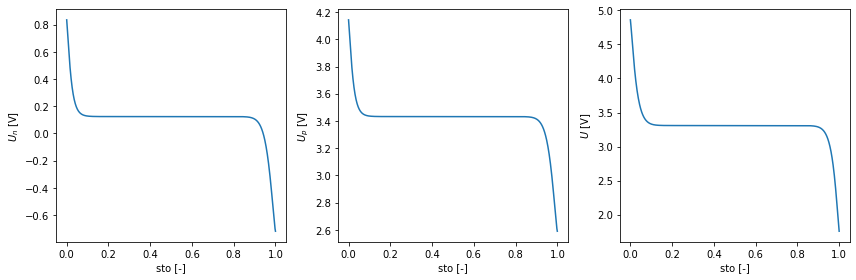

In [6]:
x = pybamm.linspace(0, 1, 1000)  # sto
U_n = parameter_values["Negative electrode OCP [V]"]
U_p = parameter_values["Positive electrode OCP [V]"]

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].plot(x.entries, U_n(x).entries)
ax[0].set(xlabel="sto [-]", ylabel="$U_n$ [V]")
ax[1].plot(x.entries, U_p(x).entries)
ax[1].set(xlabel="sto [-]", ylabel="$U_p$ [V]")
ax[2].plot(x.entries, U_p(x).entries - U_n(1-x).entries)
ax[2].set(xlabel="sto [-]", ylabel="$U$ [V]")
plt.tight_layout()

**Solving Single particle model for non-equipotential CCs**

In [7]:
electrochemical_model = pybamm.lithium_ion.SPM(options=options_spm)
sim_spm = pybamm.Simulation(electrochemical_model, parameter_values=parameter_values )
sol_spm = sim_spm.solve(t_eval= t_eval)
# plt.title("I(t), V(t), - CC potential and + CC potential (SPM: Linear BV) 2C-crate")
pybamm.dynamic_plot(sol_spm, output_variables, time_unit="seconds")

CC_density_spm = sol_spm["Current collector current density [A.m-2]"]

interactive(children=(FloatSlider(value=0.0, description='t', max=1799.0, step=17.99), Output()), _dom_classes…

In [8]:
CC_density_spm = sol_spm["Current collector current density [A.m-2]"].entries
# cathode_cc_potential = sol_spm["Current collector current density [A.m-2]"].entries
# ce = sol_spm["Current collector current density [A.m-2]"]
CC_density_spm
np.shape(CC_density_spm)

(10, 10, 1801)

In [9]:
cumulative_arr_spm = np.cumsum(CC_density_spm, axis=2)
np.shape(cumulative_arr_spm)
np.shape(cumulative_arr_spm[:,:,0])
# axes[0,0].imshow(cumulative_arr[:,:,100], cmap='viridis')
# plt.show()

(10, 10)

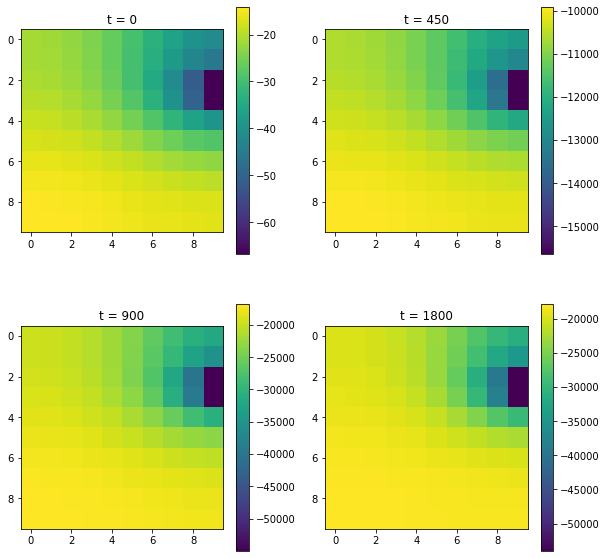

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2)

fig.set_size_inches(10, 10)

# Define the t-slices you want to plot
t_slices = [0, round(tend/4), round(tend/2), round(tend)]

# Loop over the rows and columns of the axes array
for i in range(2):
    for j in range(2):
        # Calculate the index of the current z-slice
        k = i*2 + j
        
        # Plot the image for the current z-slice
        im = axes[i,j].imshow(cumulative_arr_spm[:,:,t_slices[k]], cmap='viridis')#, vmin=0, vmax=1)
        
        # Set the title of the subplot
        axes[i,j].set_title(f"t = {t_slices[k]}")
        
        # Add a colorbar for the current subplot
        cbar = fig.colorbar(im, ax=axes[i,j])
        
# Show the plot
plt.show()


In [11]:
# Access the negative electrode surface concentration at the last time step
c_s_n_surf = sol_spm["X-averaged negative particle surface concentration [mol.m-3]"].entries

# Print the negative electrode surface concentration
print(c_s_n_surf)


[[[ 2000.          2003.7200045   2007.52067321 ...  5405.9823395
    5406.00855291  5406.03477116]
  [ 2000.          2003.78009818  2007.63406074 ...  5425.85284214
    5425.87117     5425.88950682]
  [ 2000.          2003.94094364  2007.9376605  ...  5482.75784901
    5482.75565461  5482.75347819]
  ...
  [ 2000.          2006.19914842  2012.1808969  ...  6773.40653979
    6773.26650922  6773.12649711]
  [ 2000.          2006.71473374  2013.14467137 ...  7167.12466318
    7166.98083042  7166.83701471]
  [ 2000.          2006.97222566  2013.62417022 ...  7375.304191
    7375.15848342  7375.01279267]]

 [[ 2000.          2003.70387364  2007.48854996 ...  5398.29098138
    5398.31782981  5398.34468367]
  [ 2000.          2003.7576607   2007.59008597 ...  5416.00107409
    5416.02085379  5416.04064263]
  [ 2000.          2003.91819446  2007.89299314 ...  5472.11454871
    5472.11354307  5472.11255596]
  ...
  [ 2000.          2006.43892397  2012.62367643 ...  6954.6791173
    6954.53209

** Solving Single particle Chemomechanical model for non-equipotential CCs**


In [12]:
Chemomechanical_model = MSPM(options=options_mpm)
sim_mpm = pybamm.Simulation(Chemomechanical_model, parameter_values=parameter_values )
sol_mpm = sim_mpm.solve(t_eval= t_eval)
# plt.title("I(t), V(t), - CC potential and + CC potential (Chemomechanica) 2C-crate")
pybamm.dynamic_plot(sol_mpm, output_variables, time_unit="seconds")


interactive(children=(FloatSlider(value=0.0, description='t', max=1799.0, step=17.99), Output()), _dom_classes…

In [13]:
CC_density_mech = sol_mpm["Current collector current density [A.m-2]"].entries
cumulative_arr_mech = np.cumsum(CC_density_mech, axis=2)
# np.shape(cumulative_arr_mech)
# np.shape(cumulative_arr_mech[:,:,0])
# axes[0,0].imshow(cumulative_arr[:,:,100], cmap='viridis')
# plt.show()


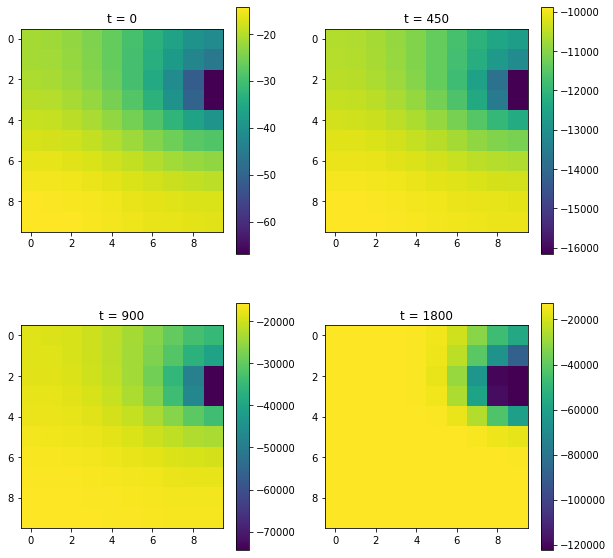

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(10, 10)

# Define the t-slices you want to plot
t_slices = [0, round(tend/4), round(tend/2), round(tend)]

# Loop over the rows and columns of the axes array
for i in range(2):
    for j in range(2):
        # Calculate the index of the current z-slice
        k = i*2 + j
        
        # Plot the image for the current z-slice
        im = axes[i,j].imshow(cumulative_arr_mech[:,:,t_slices[k]], cmap='viridis')#, vmin=0, vmax=1)
        
        # Set the title of the subplot
        axes[i,j].set_title(f"t = {t_slices[k]}")
        
        # Add a colorbar for the current subplot
        cbar = fig.colorbar(im, ax=axes[i,j])
        
# Show the plot
plt.show()